In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 31), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (60/60), 10.04 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

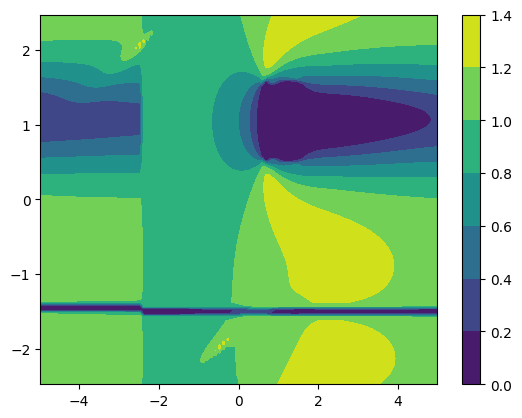

In [4]:
Nz = int(0.5*len(zc))
U = np.sqrt(uc[:,:,Nz]**2+vc[:,:,Nz]**2)
Xc, Yc = np.meshgrid(xc,yc)

fig, ax = plt.subplots()
tcf = ax.contourf(Xc, Yc, np.transpose(U))
fig.colorbar(tcf)

In [125]:
# set_batch
Nx = 10
Ny = 10
ub = uc[:,:,Nz].reshape(-1,Nx,Ny)
vb = vc[:,:,Nz].reshape(-1,Nx,Ny)
x = np.stack([ub,vb], axis=-1)
x = np.swapaxes(x, 1,3) # x[batch_size,channel,height,width]

# normalize
N = len(x[:,0,0,0]) # N : batch_size
ave = np.zeros(N)
for i in range(N):
  ave[i] = 0.5e0*(x[i,0,:,:].mean()+x[i,1,:,:].mean())
  x[i,0,:,:] = np.divide(x[i,0,:,:],ave[i])
  x[i,1,:,:] = np.divide(x[i,1,:,:],ave[i])

In [126]:
class RotatedConv1(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super(RotatedConv1, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

  def rotate_filter(self, k):
    return torch.rot90(self.conv.weight, k, dims=(2, 3))

  def forward(self, x):
    x1 = F.conv2d(x, self.rotate_filter(1), stride=1, padding=0)
    x2 = F.conv2d(x, self.rotate_filter(2), stride=1, padding=0)
    x3 = F.conv2d(x, self.rotate_filter(3), stride=1, padding=0)
    x4 = F.conv2d(x, self.rotate_filter(4), stride=1, padding=0)
    return x1,x2,x3,x4

class GCNN(nn.Module):
  def __init__(self):
    super(GCNN, self).__init__()
  def forward(self, x):
    # Z2-P4 conv
    x1,x2,x3,x4 = RotatedConv1(in_channels=2, out_channels=2, kernel_size=3)(x)

    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    print("x1")
    print(x1[0,0,:,:])
    print("x2")
    print(x2[0,0,:,:])
    print("x3")
    print(x3[0,0,:,:])
    print("x4")
    print(x4[0,0,:,:])
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    return x

In [127]:
X = torch.tensor(x)                 # x[batch_size,channel,height,width]

# initialize model
model = GCNN()
print("original")
x1 = model(torch.rot90(X,dims=(2,3))) # rotate input 90 degree
print("rotated")
x2 = model(X)
X1 = x1.detach().numpy()
X2 = x2.detach().numpy()

original
x1
tensor([[ 0.0540,  0.0164, -0.0170, -0.0294, -0.0072,  0.0159,  0.0402],
        [ 0.4411,  0.4175,  0.3881,  0.3534,  0.3145,  0.2723,  0.2281],
        [ 0.4411,  0.4518,  0.4617,  0.4699,  0.4756,  0.4782,  0.4782],
        [ 0.4410,  0.4518,  0.4617,  0.4699,  0.4756,  0.4782,  0.4782],
        [ 0.3421,  0.3421,  0.3500,  0.3598,  0.3703,  0.3815,  0.3931],
        [ 0.3421,  0.3421,  0.3053,  0.3025,  0.3046,  0.3073,  0.3126],
        [ 0.6032,  0.3771,  0.3506,  0.3432,  0.3368,  0.3297,  0.3197]],
       grad_fn=<SliceBackward0>)
x2
tensor([[0.2727, 0.2667, 0.2585, 0.2480, 0.2352, 0.2204, 0.2042],
        [0.2865, 0.2865, 0.2864, 0.2860, 0.2854, 0.2845, 0.2834],
        [0.2865, 0.2865, 0.2864, 0.2860, 0.2854, 0.2845, 0.2834],
        [0.2944, 0.2920, 0.2897, 0.2874, 0.2851, 0.2831, 0.2834],
        [0.2944, 0.2920, 0.2937, 0.2975, 0.2991, 0.2994, 0.2994],
        [0.8741, 0.6021, 0.3558, 0.3236, 0.3158, 0.3100, 0.3039],
        [0.8741, 0.6021, 0.3558, 0.3236, 0.3

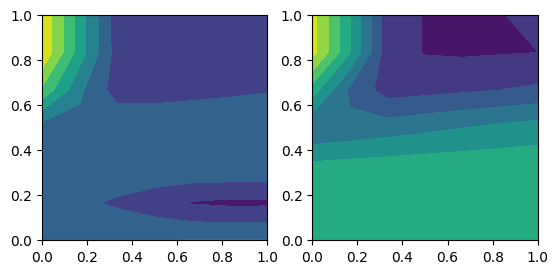

In [128]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,len(x1[0,0,0,:])),np.linspace(0,1,len(x1[0,0,:,0])))

fig, axes = plt.subplots(1,2)
tcf = axes[0].contourf(Xc, Yc, X1[0,0,:,:])
axes[0].set_aspect('equal')
tcf = axes[1].contourf(Xc, Yc, np.rot90(X2[0,0,:,:],k=1)) # rotate output 90 degree
axes[1].set_aspect('equal')